In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.1     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.8      ✔ rsample   0.0.7 
✔ infer     0.5.3      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.1.3 
✔ parsnip   0.1.3    

## Predicting Graduate School Admission Rates (Project Proposal)
DSCI 100 Group 21
- Benjamin Chang (14554159)
- Michael Sekatchev (58850397)
- Hatice Sila Yildiz (97630230)
- Weicong Zhang (11877164) 

Word Count: 560

### Introduction
Our project seeks to answer the question: Given scores on standardized tests, academic and non-academic components, what are the chances of admission to graduate school?

Undergraduate students are often concerned with admission statistics and their chances of admission, which is why we were interested in creating a model that could predict one’s chances of admissions based on certain factors shown below:

**Standardized Testing**
- `GRE.score`
- `TOEFL.score`

**Academics**
- `CGPA`
- `Research` (0 = None, 1 = Has Experience)

**Non-Academic**
- `Statement of Purpose` (SOP):Measured from 1-5, 5 being strongest)
- `Letter of Recommendation` (LOR:Measured from 1-5, 5 being strongest)

The dataset is created by Mohan S. Acharya, and is publicly accessible on Kaggle as a csv file. It contains 400 observations (rows).

### Preliminary exploratory data analysis
Our dataset is from a csv file found on Kaggle, which we uploaded onto Github and loaded into R with a direct link. A bit of tidying has been done to edit the column names and change certain categorical features into factors. 

In [2]:
data <- read_csv("https://raw.githubusercontent.com/msekatchev/DSCI100Project/main/Admission_Predict.csv")
names(data)<-str_replace_all(names(data), c(" " = "." , "," = "" ))
data <- mutate(data, University.Rating = as_factor(University.Rating))
data <- mutate(data, Research = as_factor(Research))
head(data)

Parsed with column specification:
cols(
  `Serial No.` = col_double(),
  `GRE Score` = col_double(),
  `TOEFL Score` = col_double(),
  `University Rating` = col_double(),
  SOP = col_double(),
  LOR = col_double(),
  CGPA = col_double(),
  Research = col_double(),
  `Chance of Admit` = col_double()
)



Serial.No.,GRE.Score,TOEFL.Score,University.Rating,SOP,LOR,CGPA,Research,Chance.of.Admit
<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65
6,330,115,5,4.5,3.0,9.34,1,0.90


A summary of our data can be shown below. Since the columns `University.Rating` and `Research` are categorical variables, the summary function gives a count of each possible value.


In [3]:
admissions_split <- initial_split(data, prop = 0.75, strata = Chance.of.Admit)
admissions_training <- training(admissions_split)
admissions_testing <- testing(admissions_split)
summary(admissions_training)

   Serial.No.      GRE.Score      TOEFL.Score    University.Rating
 Min.   :  1.0   Min.   :290.0   Min.   : 92.0   1:20             
 1st Qu.: 91.0   1st Qu.:308.0   1st Qu.:103.0   2:79             
 Median :197.0   Median :316.0   Median :107.0   3:99             
 Mean   :197.6   Mean   :316.6   Mean   :107.3   4:54             
 3rd Qu.:301.0   3rd Qu.:325.0   3rd Qu.:112.0   5:49             
 Max.   :400.0   Max.   :340.0   Max.   :120.0                    
      SOP            LOR             CGPA       Research Chance.of.Admit 
 Min.   :1.00   Min.   :1.000   Min.   :6.800   0:136    Min.   :0.3400  
 1st Qu.:2.50   1st Qu.:3.000   1st Qu.:8.180   1:165    1st Qu.:0.6400  
 Median :3.50   Median :3.500   Median :8.600            Median :0.7300  
 Mean   :3.44   Mean   :3.487   Mean   :8.603            Mean   :0.7255  
 3rd Qu.:4.00   3rd Qu.:4.000   3rd Qu.:9.040            3rd Qu.:0.8300  
 Max.   :5.00   Max.   :5.000   Max.   :9.920            Max.   :0.9700  

### To make the data easier to visualize, we can put it into a dataframe shown below: 

In [4]:
do.call(cbind, lapply(admissions_training, summary))

Warning message in (function (..., deparse.level = 1) :
“number of rows of result is not a multiple of vector length (arg 4)”


,Serial.No.,GRE.Score,TOEFL.Score,University.Rating,SOP,LOR,CGPA,Research,Chance.of.Admit
Min.,1.0000,290.000,92.0000,20,1.000000,1.000000,6.800000,136,0.3400000
1st Qu.,91.0000,308.000,103.0000,79,2.500000,3.000000,8.180000,165,0.6400000
Median,197.0000,316.000,107.0000,99,3.500000,3.500000,8.600000,136,0.7300000
Mean,197.6013,316.598,107.3123,54,3.440199,3.486711,8.602824,165,0.7255482
3rd Qu.,301.0000,325.000,112.0000,49,4.000000,4.000000,9.040000,136,0.8300000
Max.,400.0000,340.000,120.0000,20,5.000000,5.000000,9.920000,165,0.9700000


The columns `University.Rating` and `Research` are a bit odd because the summary statistics for the categorical variables aren’t being loaded properly. To get an initial feel for the data through visualization, we’ve plotted GPA vs Chances of Admission with a distinction on whether or not the applicant has research experience.

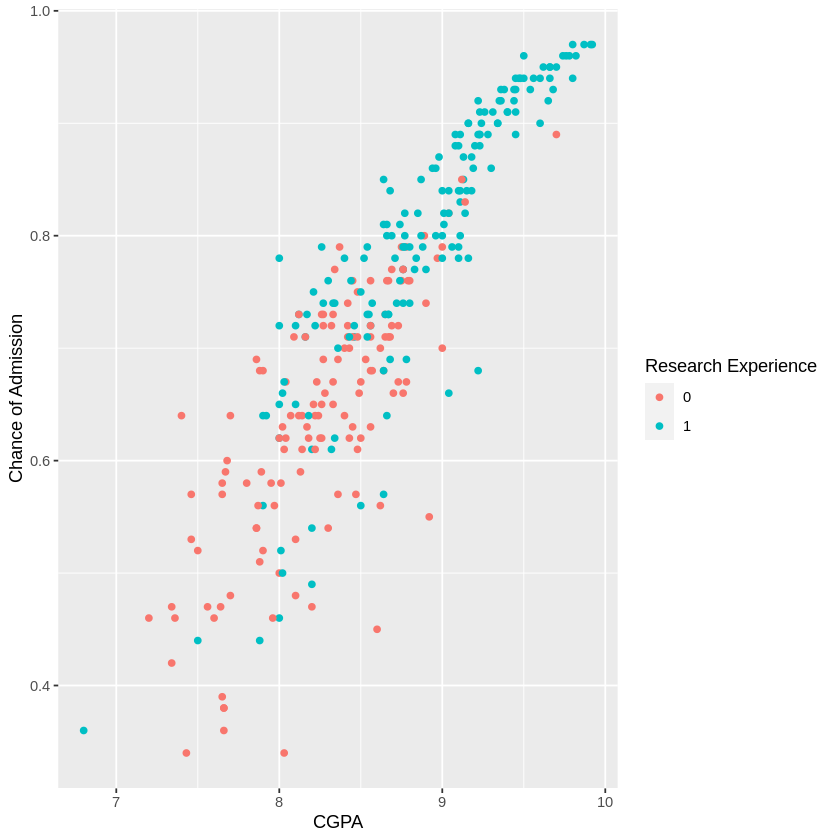

In [5]:
plot <- ggplot(admissions_training, aes(x=CGPA, y=Chance.of.Admit, color = Research)) +
    geom_point() +
    labs(x = "CGPA", y = "Chance of Admission", color = "Research Experience")
plot

We can see there is a strong positive linear relationship between GPA and the admissions chance, and that students with research experience tend to have higher chances of being admitted.

### Methods
Our data has already been cleaned and prepared for analysis above: column names are edited for easier readability and categorical features are transformed into factor types. The data will be split into training/testing (75:25).

We will build a KNN regression model that predicts the chance of admission based on all features except serial number and university rating because we don't consider them relevant. Before building the actual model, we will first perform a 5-fold cross-validation to tune for the optimal hyperparameter `neighbors` and then build our final model based on the results of the tuning. 

An interesting visualization we plan on making is to calculate a new column called `total_score` and plotting Admission Chance vs Total Score to see how well our predictions (a line we will plot) match the actual admission chances (the scatter points). This `total_score` column will not be used in the model training but rather to help visualize our model by concatenating all the predictors into one value. The plot will also help us determine if our model is overfitting or underfitting the data. 

### Expected outcomes and significance:
We expect to see rows with higher scores in any category (GPA, GRE, etc.) to predict a higher admission chance since we expect higher testing scores or stronger references to increase one's chances of admission. The results of our model can help aspiring graduate students determine what scores to aim for or which features to prioritize to maximize their chances of graduate school admission. Future explorations could include performing an analysis on feature importances to see which category contributes the most to admission chances or seeing how well our model can be generalized to universities worldwide.


### References 
- Mohan S Acharya, Asfia Armaan, Aneeta S Antony : A Comparison of Regression Models for Prediction of Graduate Admissions, IEEE International Conference on Computational Intelligence in Data Science 2019, https://www.kaggle.com/mohansacharya/graduate-admissions